In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [18]:
file_path = "../resources/data/output/online_retail_final.csv"   
df = pd.read_csv(file_path)

In [19]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,2010,1,12,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,2010,1,12,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,2010,1,12,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,2010,1,12,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,2010,1,12,20.34


In [20]:
df.shape

(390352, 12)

**Standardize Data**

In [21]:
def standardize_data(data):
    """Standardizes the data using the MinMaxScaler."""
    try:
        # Check if the input data is a pandas DataFrame
        if not isinstance(data, pd.DataFrame):
            raise ValueError("Input data must be a pandas DataFrame")

        # Check if the DataFrame contains the expected columns
        required_columns = ["Quantity", "UnitPrice"]
        if not all(column in data.columns for column in required_columns):
            raise ValueError("DataFrame must contain 'Quantity' and 'UnitPrice' columns")

        # Check if the data is numeric
        if not pd.api.types.is_numeric_dtype(data["Quantity"]) or not pd.api.types.is_numeric_dtype(data["UnitPrice"]):
            raise ValueError("Data must be numeric")

        # Create a MinMaxScaler model
        scaler = MinMaxScaler()

        # Fit the model to the data and transform the data
        data[["Quantity", "UnitPrice"]] = scaler.fit_transform(data[["Quantity", "UnitPrice"]])

        return data
    except Exception as e:
        print(f"Failed to standardize data: {e}")

In [22]:
# Standardize data
std_df = standardize_data(df)

**Calculate RFM values**

In [23]:
from scipy import stats

def box_cox_transform(data):
    """
    Apply Box-Cox transformation to make data more normal-like.
    Returns transformed data and optimal lambda value.
    """
    # Add small constant to make all values positive (Box-Cox requires positive values)
    offset = np.abs(data.min()) + 1 if data.min() <= 0 else 0
    data_offset = data + offset
    
    # Find optimal lambda value and transform the data
    transformed_data, lambda_param = stats.boxcox(data_offset)
    
    return transformed_data, lambda_param

In [24]:
def calculate_rfm(data):
    """Calculates the RFM values for each customer."""
    # Calculate the Recency (R) value
    data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
    data['Recency'] = (data['InvoiceDate'].max() - data['InvoiceDate']).dt.days

    # Calculate the Frequency (F) value
    data_freq = data.groupby('CustomerID')['InvoiceNo'].count().reset_index()
    data_freq.columns = ['CustomerID', 'Frequency']
    data = pd.merge(data, data_freq, on='CustomerID')

    # Calculate the Monetary (M) value
    data['TotalSpent'] = data['Quantity'] * data['UnitPrice']
    data_monet = data.groupby('CustomerID')['TotalSpent'].sum().reset_index()
    data_monet.columns = ['CustomerID', 'Monetary']
    data = pd.merge(data, data_monet, on='CustomerID')

    # Logarithmic transformation
    data['LogRecency'] = np.log1p(data['Recency'])
    data['LogFrequency'] = np.log1p(data['Frequency'])
    
    data['LogMonetary'] = np.log1p(data['Monetary'])
    # data['LogMonetary'], lambda_val = box_cox_transform(data['Monetary'])
    # To transform back to original scale:
    #original_scale = np.exp(transformed_monetary) if lambda_val == 0 else (transformed_monetary * lambda_val + 1) ** (1/lambda_val)

    # Calculate the RFM score
    data['RFM'] = data['LogRecency'] + data['LogFrequency'] + data['LogMonetary']

    return data

In [25]:
rfm_df = calculate_rfm(std_df)

**Plot RFM distribution**

In [26]:
rfm_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,TotalPrice,Recency,Frequency,TotalSpent,Monetary,LogRecency,LogFrequency,LogMonetary,RFM
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,0.001570,2010-01-12 08:26:00,0.010196,17850.0,United Kingdom,2010,1,12,15.30,697,297,0.000016,0.005292,6.548219,5.697093,0.005278,12.25059
1,536365,71053,WHITE METAL LANTERN,0.001570,2010-01-12 08:26:00,0.013556,17850.0,United Kingdom,2010,1,12,20.34,697,297,0.000021,0.005292,6.548219,5.697093,0.005278,12.25059
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,0.002198,2010-01-12 08:26:00,0.010996,17850.0,United Kingdom,2010,1,12,22.00,697,297,0.000024,0.005292,6.548219,5.697093,0.005278,12.25059
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,0.001570,2010-01-12 08:26:00,0.013556,17850.0,United Kingdom,2010,1,12,20.34,697,297,0.000021,0.005292,6.548219,5.697093,0.005278,12.25059
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,0.001570,2010-01-12 08:26:00,0.013556,17850.0,United Kingdom,2010,1,12,20.34,697,297,0.000021,0.005292,6.548219,5.697093,0.005278,12.25059


In [27]:
rfm_df.drop(columns=['CustomerID', 'InvoiceNo', 'InvoiceDate', 'StockCode','Year', 'Month', 'Day']).describe()

,Quantity,UnitPrice,TotalPrice,Recency,Frequency,TotalSpent,Monetary,LogRecency,LogFrequency,LogMonetary,RFM
count,390352.000000,390352.000000,390352.000000,390352.000000,390352.000000,390352.000000,390352.000000,390352.000000,390352.000000,390352.000000,390352.000000
mean,0.003182,0.011708,18.167341,172.134089,650.183824,0.000019,0.009616,4.751234,5.370819,0.009269,10.131322
std,0.008058,0.016527,27.073678,130.605389,1421.046325,0.000033,0.025882,1.072813,1.372296,0.023988,1.741768
min,0.000000,0.000000,0.001000,0.000000,1.000000,0.000000,0.000000,0.000000,0.693147,0.000000,1.098725
25%,0.000314,0.004996,4.950000,61.000000,88.000000,0.000002,0.000914,4.127134,4.488636,0.000914,9.013877
50%,0.001570,0.007796,11.900000,154.000000,196.000000,0.000012,0.002435,5.043425,5.283204,0.002432,10.172938
75%,0.003454,0.014996,19.800000,255.000000,441.000000,0.000020,0.005699,5.545177,6.091310,0.005682,11.253070
max,1.000000,1.000000,275.000000,697.000000,7675.000000,0.000342,0.242575,6.548219,8.945854,0.217186,15.519760


**Histogram**

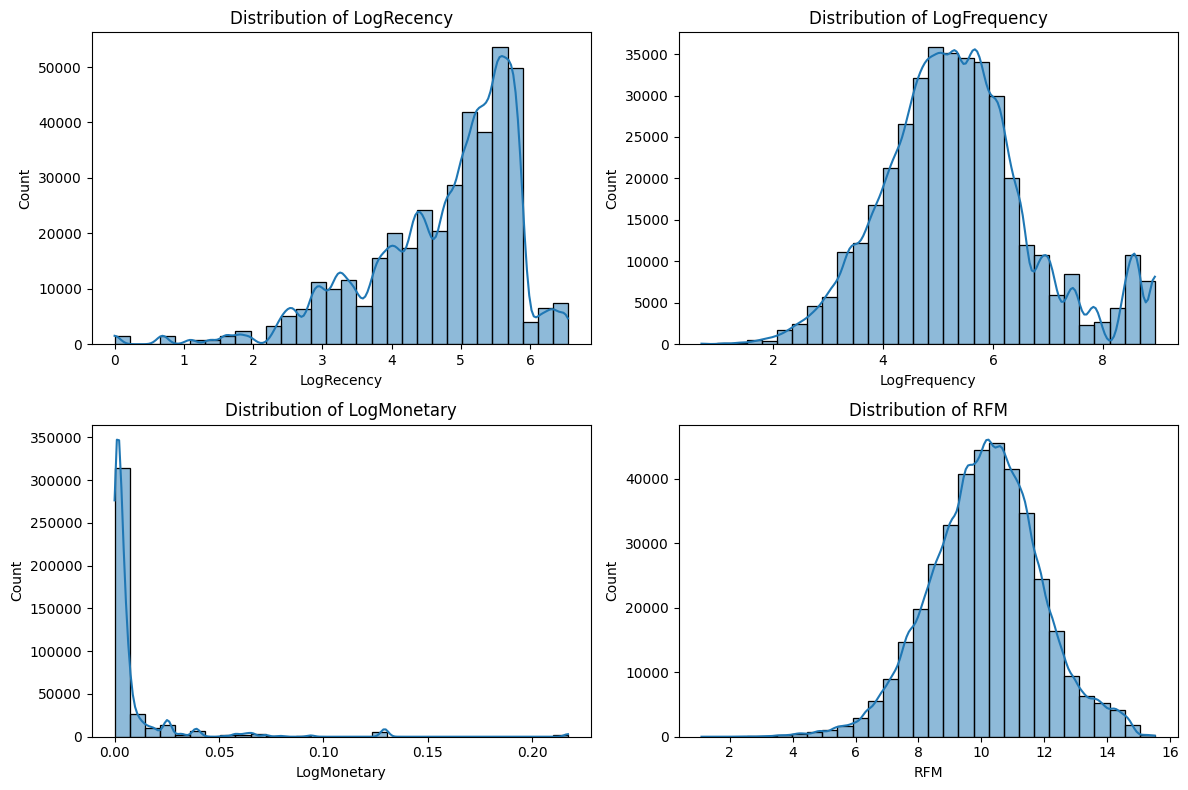

In [28]:
columns = ['LogRecency', 'LogFrequency', 'LogMonetary', 'RFM']  
plt.figure(figsize=(12, 8))  

for i, col in enumerate(columns):  
    plt.subplot(2, 2, i+1)  
    sns.histplot(rfm_df[col], bins=30, kde=True)  
    plt.title(f'Distribution of {col}')  

plt.tight_layout()  
plt.show()

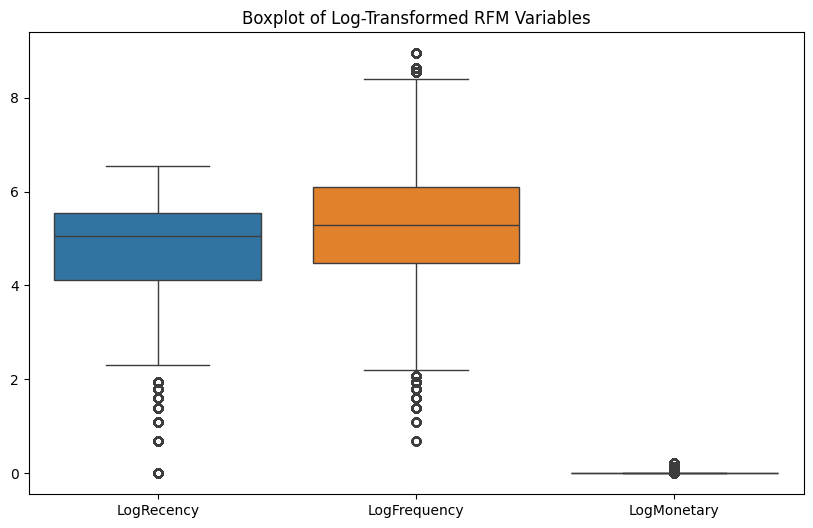

In [29]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=rfm_df[['LogRecency', 'LogFrequency', 'LogMonetary']])
plt.title("Boxplot of Log-Transformed RFM Variables")
plt.show()

**Correlation Check for Clustering**

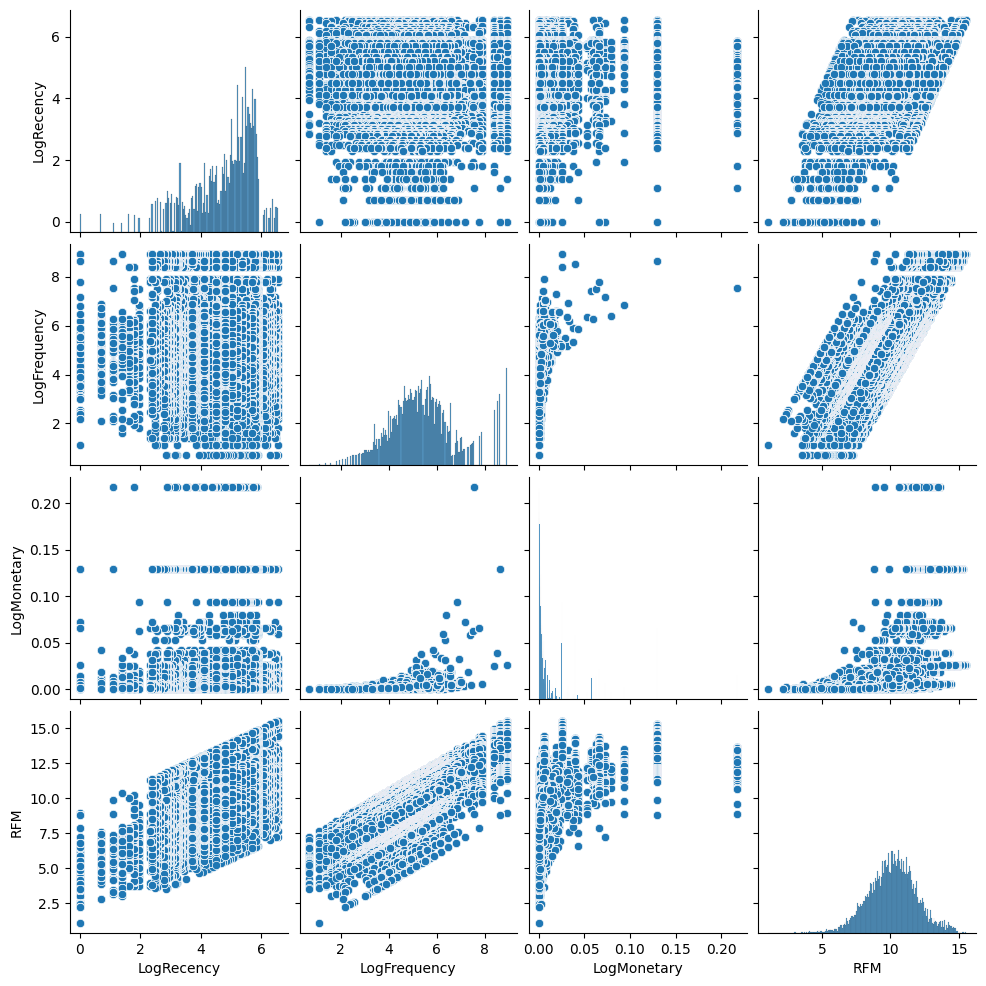

In [30]:
sns.pairplot(rfm_df[['LogRecency', 'LogFrequency', 'LogMonetary', 'RFM']])
plt.show()

In [31]:
rfm_df.to_csv('../resources/data/output/online_retail_rfm_kmeans.csv', index=False)